*updated 16 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 4. Introduction to neural networks and MLPs

***Neural Networks*** form a large part of modern day machine learning. Recall that the problem of regression or supervised learning is to find $N$ in $N(X) = Y$ given inputs and outputs $X$ and $Y$. [***Universal approximation theorems***](https://en.wikipedia.org/wiki/Universal_approximation_theorem) essentially say that with enough complexity these neural networks can approximate functions $f$ with sensible properties arbitrarily well. We are more or less going to focus on neural networks for the rest of the course. 

The first of these sessions will introduce the anatomy of what actually goes into neural networks and the principles behind how these networks are trained, illustrating these with particularly simple network architectures. The remaining lectures can then be regarded as theme and variations on this: the details differ, but the ideas remain largely the same. We are going to use the [***PyTorch***](https://pytorch.org/) interface, and various capabilities with PyTorch will be introduced in steps (rather than all of it one go, because there is quite a lot of it).

> ## Key Objective(s)
> 1. Basic anatomy of a neural network as an approximation of an operator.
> 2. Training of neural networks via back-propagation and (stochastic) gradient descent.
> 3. Perceptrons and Multi-Layer Perceptrons as a basis of neural networks.
> 4. Basic usage of `PyTorch` for building and training of neural networks.

Note that the implementation in this first session will be quite "raw", in that we do the things in a reasonably rudimentary way. There are better ways of doing it through `PyTorch` functionalities that we will gradually introduce.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

---
## a) Background concepts

Below is a schematic of a neural network $N$ I cooked up for illustrating the key parts of a neural network and what it does.

<img src="https://i.imgur.com/LFTTTa5.jpeg" width="600" alt='schematic neural network'>

The basic idea of a neural network is a thing that takes input $X$ and predicts a $\hat{Y}$. In my case this neural network has one single ***hidden layer*** (the components between the two purple lines) consisting of two nodes denoted $h_1$ and $h_2$. The $h_1$ and $h_2$ do elementary operations on the $X = (x_1, x_2)$ as
\begin{equation*}
    h_1 = f(w_1 x_1 + w_3 x_2 + b_1), \qquad h_2 = f(w_2 x_1 + w_4 x_2 + b_2).
\end{equation*}

We have:
* $w_i$ are the ***weights*** associated with the nodes that multiplies to the input(s).
* $b_i$ are the ***biases*** that get added.
* $f$ is called an ***activation function*** that eats some numbers and spits out another number.

> NOTE: In some manuals these may be referred to as ***affine transformations***.

In the end $N$ eats some numbers and spits some stuff out: this would be the ***feed-forward*** (the terminology is presumbly drawn from *control theory* in the engineering field).

To see a feed-forward in action, I'll do one of these calculations manually; the below will be a code version of this. Suppose $X = [-1, 1]$, and my weight vector is $w = (1, 2, 3, 4)$, my biases are $b = (0, 1)$, and I my activation function is trivial, i.e. I have the identify function $f(x) = x$ for all values. Then at $h_1$, I have the following intermediate steps:

1. $x_1 w_1 + x_2 w_3 + b_1 = (-1)(1) + (1)(3) + 0 = -1 + 3 + 0 = 2$
2. $f(x_1 w_1 + x_2 w_3 + b_1) = f(2) = 2$

So $h_1(X) = 2$. Convince yourself that $h_2(X) = 3$, thus $N(X) = \hat{Y} = 2 + 3 = 5$. A coded up version of it looks like the below: I lumped $w$ and $b$ into an array variable called $\theta$ (`theta`).

In [2]:
def simple_nn(X, theta, activation="unity"):
    # pull out relevant numbers
    x_1, x_2 = X
    w_1, w_2, w_3, w_4 = theta[:4]
    b_1, b_2 = theta[4:]

    # compute arguments (note this could be written as a matrix multiplication)
    h_1 = w_1 * x_1 + w_3 * x_2 + b_1
    h_2 = w_2 * x_1 + w_4 * x_2 + b_2

    # pass through activation function
    match activation:
        case "unity":
            h_1, h_2 = h_1, h_2
        case "tanh":
            h_1, h_2 = np.tanh(h_1), np.tanh(h_2)

    # return final output
    return h_1 + h_2

X = (-1, 1)
theta = (1,2,3,4,0,1)

print(f"output of simple_nn(X) is {simple_nn(X, theta):.6f}")
print(" ")

output of simple_nn(X) is 5.000000
 


### Activation functions

While I didn't do it above, try and convince yourself that as long as I deal don't have a non-trivial ***activation function*** then most things I wrote above can in fact be written as a matrix multiplication. That's not entirely surprising in hindsight, because my nodes and each of the hidden layers are just doing sums and additions, i.e. linear operations, and linear operations (or affine transformations) can be represented by matrices. Each hidden layer $\ell$ is represented by a matrix $A_\ell$, but
\begin{equation*}
    A_1(X) = a_1, \quad A_2(a_1) = a_2, \quad \ldots A_M(a_{M-1}) = \hat{Y}
\end{equation*}
is really just
\begin{equation*}
    A_M(\ldots A_3(A_2(A_1(X)))) = A(X) = \hat{Y},
\end{equation*}
so our task just boils down to finding $A$.

However, we don't want to just stick with linear operations, because that is somewhat limited. One way that neural networks add in nonlinearity is through ***activation functions*** $f$. Then we have instead
\begin{equation*}
    A_1(X) = f(a_1), \quad A_2(f(a_1)) = f(a_2), \quad \ldots A_M(f(a_{M-1})) = \hat{Y}
\end{equation*}
but the chain $A_M(\ldots A_3(A_2(A_1))) = A$ no longer holds because there is nonlinearity. The universal approximation theorems applies to this case, so we can build a wider variety of operators from simple components.

Common activation functions are illustrated below. Some of these you have seen already in another form: they are just flipped versions of the one-sided loss functions from when we were doing classification. Indeed, the code below I literally just copied and pasted from a previous lecture and modified/deleted a few lines...

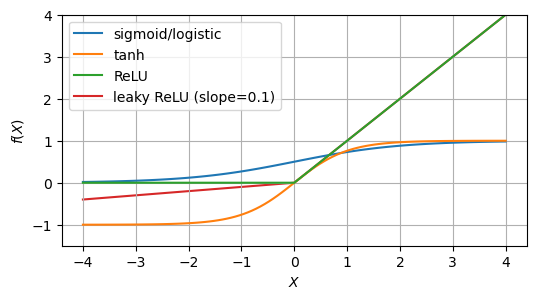

In [3]:
# sample activation functions

slope = 0.1

X = np.linspace(-4, 4, 101)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(X, 1.0 / (1.0 + np.exp(-X)), label="sigmoid/logistic")
ax.plot(X, np.tanh(X), label="tanh")
ax.plot(X, np.maximum(X, 0), label="ReLU")
ax.plot(X, slope * np.minimum(X, 0) + np.maximum(X, 0), label=f"leaky ReLU (slope={slope})",
        zorder=-1)  # force it to be below other plots
ax.set_ylim((-1.5, 4))
ax.legend()
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$f(X)$")
ax.grid();

The idea of activations are that they are at least piecewise-differentiable (for reasons to be detailed later), and control the value of the outcome. The examples given above are:

* ***Sigmoid*** generally refers to something that is $S$-shaped, and one example is the ***logistic function*** demonstrated above. This example is bounded between [0, 1].
* ***Hyperbolic-tangent*** (or tanh) is like the above. The standard form is bounded between [-1, 1].
* ***Rectified Linear Unit*** or (ReLU) is like the flipped version of the hinge loss from before, and the standard form is bounded below by zero.
* Leaky ReLU is like ReLU but has an extra part with a slope in the negative part.

The thing with sigmoid and ReLU is that if the inputs are (sufficiently) negative then you just get zero; this is refered to as a neuron not "firing" (because it spits out nothing), and partly the reason why these are called activation functions.

In the subroutine above I implemented the `tanh` activation function. The intermediate steps we have are
\begin{equation*}
    h_1(X) = \tanh(2), \qquad h_2(X) = \tanh(3),
\end{equation*}
so $\mathcal{N}(X) \approx 1.959...$, which is also what is returned by a call of the subroutine.

In [4]:
X = (-1, 1)
theta = (1,2,3,4,0,1)

# this one needs to be single quotes in not match the double quotes...
print(f"output of simple_nn(X) is now {simple_nn(X, theta, activation='tanh'):.6f}")
print(" ")

output of simple_nn(X) is now 1.959082
 


> <span style="color:red">Q.</span> Put in sigmoid and ReLU activations and see what outputs you get there (you should do these by hand to check you implemented it correctly).

### Back-propagation

So now we can do the feed-forward, how do we "train" the neural network $N$? Well again we need a measure of what it means for $N$ to do "well": we need to define a loss function $J$, possibly with penalisations added in accordingly. 

The name of the game is as before: we want to find the control parameters $\theta = (w, b)$ of the neural network $N(\theta)$ such that the loss $J$ is minimised. As before, we can leverage (stochastic) gradient-based methods in the following way. I am going to put another copy of the schematic here for convenience of reading.

<img src="https://i.imgur.com/LFTTTa5.jpeg" width="600" alt='schematic neural network'>

#### 1. Feed-forward (i.e. going from left to right) and evaluate loss $J$

Guess the initial $\theta$, do a feed-forward for the training set $X$ to generate $\hat{Y}$, and compute the loss $J(Y, \hat{Y})$. In the schematic, this is us going all the way from left to right.

#### 2. Form the optimisation problem

So we want to solve the problem (abusing notation substantially here) $\partial J / \partial \theta = 0$. Lets suppose we start with the first control variable $w_1$; thus we want to evaluate
\begin{equation*}
    \frac{\partial J}{\partial w_1}.
\end{equation*}

#### 3. Apply chain rule (i.e. tracing back from right to left)

Starting from all the way on the right, we see where $w_1$ is used. This would be in $h_1$ since $h_1 = h_1(w_1)$. By chain rule we have
\begin{equation*}
    \frac{\partial J}{\partial w_1} = \frac{\partial J}{\partial h_1}\frac{\partial h_1}{\partial w_1}.
\end{equation*}
But then we also know that $h_1 = f(w_1 x_1 + \ldots)$, so by chain rule and product rule we have
\begin{equation*}
    \frac{\partial h_1}{\partial w_1} = f'(w_1 x_1 + \ldots) + x_1 f(w_1 x_1 + \ldots).
\end{equation*}
We are now back at the beginning. All the terms above can in principle be evaluated, particularly if we choose an activation function $f$ where the derivative is reasonably simple (e.g. no activation would mean $f'=1$, ReLU will give $f'=1$ for $x>0$ and $0$ otherwise). Continue with all the other entries in $\theta$.

#### 4. Do the root finding method

The result is a whole load of algebraic equations and you want to find the roots of that. That tells you how to update your $\theta$; update that, and then repeat until you there is some convergence and/or you get bored.

You should be able to see how you might do this for arbitrary-sized networks in principle. Neural networks are constructed in such a way that ***back-propagation*** as described above by the chain rule is particularly easy to do, and is partly related to their success: gradient-based methods can be used, which speeds up convergence, so more control variables can be allowed in principle, which we can allow for more complexity in the neural network that allows for better representation of operators.

> <span style="color:red">Q.</span> Make up a set of inputs/targets and define a loss of your choice; MSE would be a particularly easy one. I would probably just do $Y = X$ or $Y = X^2$ or something like that, but use a non-trivial activation function (because otherwise you can solve the problem in one go with matrix inversion). Try and modify the weights in the subroutine manually to see how you might do it to reduce the loss.

---
## b) Single-layer Perceptrons

***Perceptrons*** is one of the early designs of a neural network. A schematic of this is shown below, for a case with a single layer and one with multiple layers (a MLP).

<img src="https://i.imgur.com/e4R4nMM.jpeg" width="600" alt='mlps'>

An earlier criticism of the single layer perceptrons is that it can only really do binary classifications on data that is linearly separable, and we can more or less do that already with SVMs. The above comment doesn't apply to the multiple layer case; in that sense MLPs shouldn't really be called perceptrons because they can do more things.

Here we are going to make use of the cats and dogs data to demonstrate a few things with single layer perceptrons. Note that the single layer perceptron basically has no hidden layers. In this case there is no nonlinearity and it really is just matrix inversion. For operator $A$, images $X$ and labels $Y$ we have
\begin{equation}
    AX = Y \quad \Rightarrow \quad A = YX^\dagger.
\end{equation}
Here $X^\dagger$ is the ***pseudo-inverse***. The system will most likely be in the over-determined regime so arrays are not going to be square, and we need to consider the problem as one of optimisation. The standard pseudo-inverse considers the problem as one of $L^2$ optimisation without a penalisation, i.e. linear regression.

Going to load the cats and dogs data and then train up the model in the old fashioned way of matrix inversion. I'm just going to use all the data for demonstration purposes.

> NOTE: We should not expect fantastic skill for the following problems with the cats and dogs data, because what I will be doing is an inherently difficult task.

In [5]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_cats = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_cats = df_cats.values

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "dog.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/dog.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_dogs = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_dogs = df_dogs.values

loading data remotely
loading data remotely


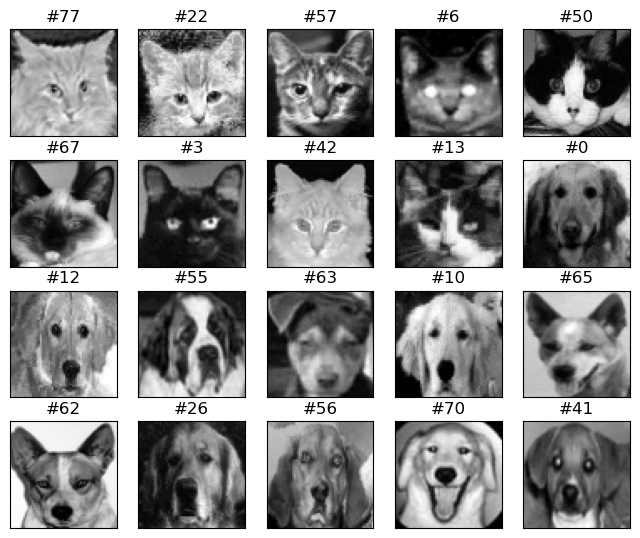

In [6]:
# generate a list of 25 indices (generate full list, shuffle, select first 25, so no repeats)
ind = np.arange(80)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

# sample show (on-the-fly reshape data)
fig = plt.figure(figsize=(8, 6.5))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    if i+1 < 10:
        ax.imshow(np.reshape(X_cats[ind[i], :], (64, 64)).T, cmap="gray")
    else:
        ax.imshow(np.reshape(X_dogs[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);

In [7]:
# shape of "cats" and "dogs" here is (pixels, index), so it is already flattened

n = 64  # take the first 80% (out of 80 entries) of the data just because

X_train = np.concatenate((X_cats[:n, :], X_dogs[:n, :]), axis=0)  # combine
Y_train = np.concatenate((np.ones(n), -1*np.ones(n)))         # label: cats = 1 and dogs = -1

X_test = np.concatenate((X_cats[n::, :], X_dogs[n::, :]), axis=0)
Y_test = np.concatenate((np.ones(80-n), -1*np.ones(80-n)))

# scale and redefine the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# obtain model by simple matrix inversion
A_pinv = Y_train @ np.linalg.pinv(X_train.T)

Having got the model (which is just a matrix here), we make make predictions. We multiply the test data set and see what number it would give us. It won't give us the label values exactly (`1` and `-1`), but it essentially say that if it is positive/negative it is `1` and `-1` respectively, i.e. we only care about the sign.

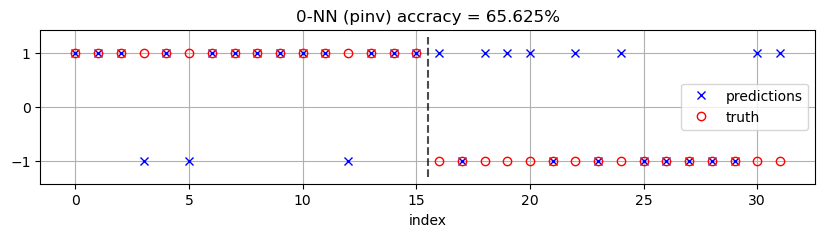

In [8]:
# test model by doing matrix multiplication (right answer is [1 1 1 ... -1 -1 -1])
Y_pred = np.sign(A_pinv @ X_test.T)  # just need the sign

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.plot([15.5, 15.5], [-1.3, 1.3], 'k--', alpha=0.7)
ax.set_xlabel("index")
ax.legend()
ax.grid()

# if Y_pred = +-1 and Y_test = +-1 (i.e. correct predictions) then Y_pred * Y_test = 1
accuracy = np.sum(Y_pred * Y_test == 1) / len(Y_pred * Y_test)
ax.set_title(f"0-NN (pinv) accracy = {accuracy*100}%");

The accuracy is not great, but again image recognition is an inherently hard problem.

The thing that is of possible interest is what does the model actually look like? We can probe this by actually plotting it out: we show below the (normalised) coeffs as a 1d array, then reshaped into an array of the same size as the image it acts on, and also plot a random image in the dataset for comparison reasons.

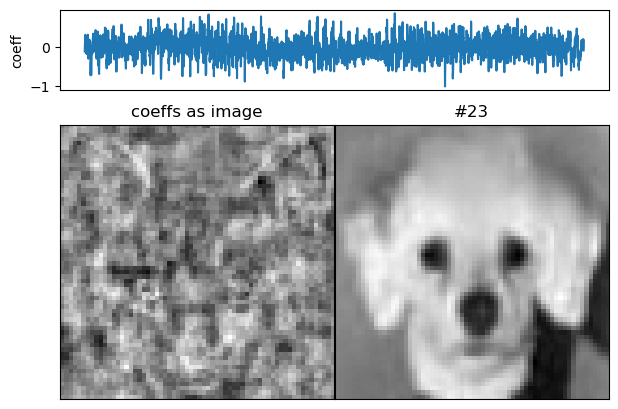

In [9]:
# plot out normalised coefficients and "power" in the image
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((4, 6), (0, 0), colspan=6)
ax.plot(A_pinv / np.max(np.abs(A_pinv)))
ax.set_ylabel(f"coeff")
ax.set_xticks([])

ax = plt.subplot2grid((4, 6), (1, 0), rowspan=3, colspan=3)
cs = ax.imshow(np.reshape(A_pinv, (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title("coeffs as image")

ind = np.random.randint(X_test.shape[0])
ax = plt.subplot2grid((4, 6), (1, 3), rowspan=3, colspan=3)
ax.imshow(np.reshape(X_test[ind, :], (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title(f"#{ind}")

plt.tight_layout(pad=0.05);

The way to think about the model $A$ as the image is that you take that $A$ and multiply the image's pixels element-wise, then sum up the numbers to get a single number. If that number is bigger than 0 then the model predicts a cat, otherwise it's a dog.

The $L^2$ regression here gave us a lot of non-zero coefficients, which is also shown in the reshaped image. Where the colours are particularly white/black is showing where the model things the pixels are important for classifying the image as cat or dog. In that sense the model has interpretability in that it thinks certain pixels are more important than others.

We then recall that if we do $L^1$ penalisation then we could promote sparsity in the coefficients for this case. We can piggyback on `sklearn.linear_model.LASSO` in this case to do the same thing. The below code demonstrates how this would be done.

> NOTE: We can do this only because the perceptron basically has no hidden layers or activation functions.
>
> Here I turned down my regularisation parameter `alpha` from the default of `1`.

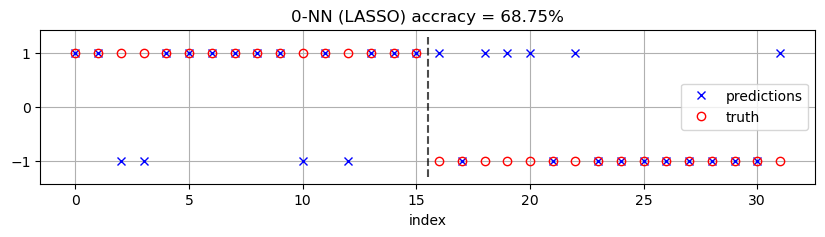

In [10]:
# inversion with LASSO
from sklearn.linear_model import Lasso

# some optimum in relation to the regulatisation parameter it seems
model = Lasso(alpha=0.1).fit(X_train, Y_train)
A_lasso = model.coef_

# test model by doing matrix multiplication (right answer is [1 1 1 ... -1 -1 -1])
Y_pred = np.sign(A_lasso @ X_test.T)  # just need the sign

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.plot([15.5, 15.5], [-1.3, 1.3], 'k--', alpha=0.7)
ax.set_xlabel("index")
ax.legend()
ax.grid()

# if Y_pred = +-1 and Y_test = +-1 (i.e. correct predictions) then Y_pred * Y_test = 1
accuracy = np.sum(Y_pred * Y_test == 1) / len(Y_pred * Y_test)
ax.set_title(f"0-NN (LASSO) accracy = {accuracy*100}%");

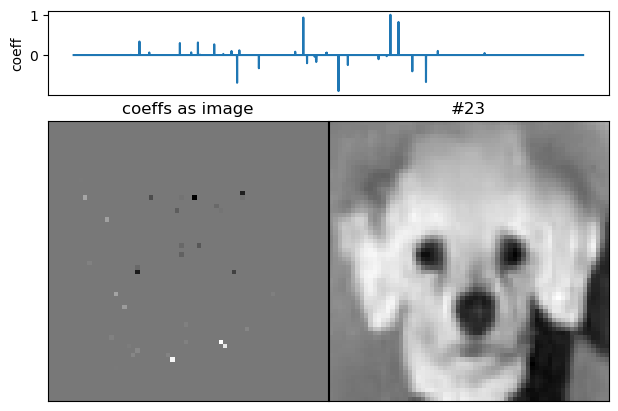

In [11]:
# plot out normalised coefficients and "power" in the image
fig = plt.figure(figsize=(6, 4))
ax = plt.subplot2grid((4, 6), (0, 0), colspan=6)
ax.plot(A_lasso / np.max(np.abs(A_lasso)))
ax.set_ylabel(f"coeff")
ax.set_xticks([])

ax = plt.subplot2grid((4, 6), (1, 0), rowspan=3, colspan=3)
cs = ax.imshow(np.reshape(A_lasso, (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title("coeffs as image")

# ind = np.random.randint(X_test.shape[0])
ax = plt.subplot2grid((4, 6), (1, 3), rowspan=3, colspan=3)
ax.imshow(np.reshape(X_test[ind, :], (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title(f"#{ind}")

plt.tight_layout(pad=0.05);

As expected there are a lot of zero coefficients, and the skill is actually slightly higher. Thing to note here is that the coefficients of the model are non-zero

* Near the eyes
* Forehead
* Near the mouth?

This is interesting because this is possibly in line with our expectations that these might be key features that are useful for cats and dogs classification. Approaches such as these may be of interest to guide our feature creation for such problems (e.g. instead of throwing the whole image in, we may want to train models to label "eyes" and "mouth" and use those as features for our eventual classifier).

> <span style="color:red">Q.</span> Consider changing the `alpha` parameter and see how skill and model changes.
>
> <span style="color:red">Q.</span> Could try other penalisations also (e.g. elastic net). 

---
## c) Usage of `pyTorch` and MLPs

While it is in principle possible to create neural networks by hand (see extended exercise in this session), there are quite a few libraries/engines out there that are designed to link up the creation of the hidden layers, loss functions, optimisers and so forth. [PyTorch](https://pytorch.org/) is one of the those that will be considered here; [TensorFlow](https://www.tensorflow.org/) is another. 

> NOTE: Ultimately the above libraries leverage interfaces for manipulating arrays/***tensors***. In principle [JAX](https://github.com/jax-ml/jax) could also do it, although PyTorch and TensorFlow have higher level calls that make the process a bit easier.
>
> I am going to keep the implementation quite "raw" in this session. We can use an interface over PyTorch and TensorFlow to make our lives even easier (e.g. `Lightning` and/or `keras`), but going to save that for the next session. 

In the below I am going to do the (multi-layer) perceptron cats and dogs classification example to demonstrate certain aspects of the engine. First going to load the appropriate data. The below code is more of less copy and paste from before, using some of the `sklearn` utilities, except a bit more work is done to create a validation set of data.

In [12]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_cats = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_cats = df_cats.values

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "dog.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/dog.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_dogs = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_dogs = df_dogs.values

seed = 42
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
test_valid_ratio = valid_ratio + test_ratio
assert train_ratio + valid_ratio + test_ratio == 1

# Expected no. of samples
print()
total_sample = 80*2
train_sample = int(train_ratio*total_sample)
valid_sample = int(valid_ratio*total_sample)
test_sample = total_sample - train_sample - valid_sample
print(f"Expected no. of samples (train, test, valid): {train_sample, test_sample, valid_sample}")

X_total = np.concatenate((X_cats, X_dogs), axis=0)
Y_total = np.concatenate((np.ones(int(total_sample/2)), np.zeros(int(total_sample/2))))

# train-(test&valid) split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_total, Y_total, test_size=test_valid_ratio, random_state=seed,)
# split test set to test and valid set
X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_test, Y_test, test_size=valid_ratio/test_valid_ratio, random_state=seed,)

# check the shape
print()
print(f"X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}; Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}; Y_test shape: {Y_test.shape}")

# # scale and redefine the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_valid, X_test = \
  scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_valid : {X_valid.min()}...{X_valid.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")

loading data remotely
loading data remotely

Expected no. of samples (train, test, valid): (112, 24, 24)

X_train shape : (112, 4096); Y_train shape: (112,)
X_valid shape: (24, 4096); Y_valid shape: (24,)
X_test shape: (24, 4096); Y_test shape: (24,)

X_train : -2.335741709402446...2.656062140273782
X_valid : -2.2980798425108357...2.604693316176747
X_test :  -2.3648983633730407...2.5768492533329166


From hereon we invoke `PyTorch` utilities. Zeroth thing we do is to load some packages. Then we are going to proceed as follows:

1) Convert the data accordingly into things `PyTorch` can manipulate
2) Define the MLP
3) Define relevant loss function and optimisers
4) Package up the parts in a training loop that is to be iterated on
5) Train the model and evaluate things accordingly

In [13]:
# load package and data
import torch
import torch.nn as nn        # where the things to define hidden layers live
import torch.optim as optim  # the optimisers used in back-propagation

### 1. Convert data into tensor objects

For the present classification problem the inputs we have were integers, and after the usual standardisation are floats, which are converted into pytorch tensors as `FloatTensor`. The outputs really are integers, and this could be done as `LongTensor` (if it is SIGNED) or `ByteTensor` (if it is UNsigned); I am going to use `LongTensor` even though I don't strictly need to (since my labels are `0` and `1`s).

> NOTE: `FloatTensor` here is `float32` rather than `float64`, respecively storing values up to 8 and 16 decimal places.

In [14]:
# data convertion in to pytorch objects
print(f"X_train array shape before = {X_train.shape}")

X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)
X_valid, Y_valid = torch.FloatTensor(X_valid), torch.LongTensor(Y_valid)

print(f"X_train tensor size after = {X_train.size()}")
print(" ")

X_train array shape before = (112, 4096)
X_train tensor size after = torch.Size([112, 4096])
 


Converting to tensor objects have some advantages with regards to reshaping and so forth, to be demonstrated later.

### 2. Define the MLP structure

The below code define the neural network structure as a class object which can be passed around.

* The model is called `nn_classify_pets`, and it includes `nn.Module` as a generic interface to receive inputs accordingly (but we won't have any here as such).
* The `__init__` initialises the class with things it needs. The `super` part is for some inheritance reasons so that the `PyTorch` interface needs to see when doing the training later.
* The main part is the structure which I wrote in one go in `self.layers`:
  - `nn.Sequential` means all the things in that part are run sequentially in the specified order.
  - `nn.Linear(64**2, 100)` takes inputs of size $64^2$ (i.e. the number of pixels in the flattened image) and pass that to 100 nodes (which is the `sklearn.MLPClassifier` default).
  - You might put then an activation function (e.g. `nn.ReLU()`), although I didn't (which was a choice I made in the last session).
  - `nn.Linear(100, 2)` then takes the 100 nodes and converts to two outputs, because in this particular classification problem I have two possibilities (cats or dogs).

> NOTE: You might argue surely I just want one number given I want to evaluate whether the numbers are closer to `0` or `1` for the classification. That's not how `PyTorch` and the related loss function works; see later.

* To wrap it up, the subroutine `forward` defines how the network does the feed-forward for loss function evaluation, which is needed for recording purposes for the back-propagation later (the recording procedure is sometimes referred to as ***taping*** or ***annotating***).

In [15]:
# define the model architecture

class nn_classify_pets(nn.Module):
    def __init__(self):  # specify input dims below
        super(nn_classify_pets, self).__init__()

        # nest it in one go
        self.layers = nn.Sequential(
            nn.Linear(64**2, 100),  # image is 64**2, 100 nodes (sklearn default)
            # nn.ReLU(),            # no activation function
            nn.Linear(100, 2)       # two possible outputs
        )

    # actual model structure: input -> hidden layer -> outputs, ReLU on input and hidden
    def forward(self, x):
        out =  self.layers(x)
        return out

Should just say that the below is an equivalent way of defining the same thing as above, but in a slightly more verbose way: I define all the components in `__init__`, then assemble it in the order I want in `forward`.

```Python
class nn_classify_pets(nn.Module):
    def __init__(self):
        super(nn_classify_pets, self).__init__()

        self.input_layer = nn.Linear(64**2, 100)
        self.output_layer = nn.Linear(100, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out =  self.input_layer(x)
        # out = self.relu(out)  # no activation function here wth comment
        out =  self.output_layer(out)
        return out
```

### 3. Initialise relevant loss function and optimisers

For the binary classification problem we can use `nn.CrossEntropyLoss()` (which is related to the information gain discussed previously), `nn.HingeEmbeddingLoss`, or some others that you can look up; going to use the first one.

For the optimiser there are a variety of these in `torch.optim`; I am going to use `optim.Adam` (which is the default in `sklearn`), but other options are the standard stochastic gradient descent `optim.SGD` or even `optim.LBFGS`, which are also options in `sklearn`. There are more solvers than the ones I have mentioned here, have a look at those if you want.

In the below I manually specify the ***learning rate*** (the step size for iteration towards the local minimum in the loss function landscape; the default if `0.001`). A larger value will speed up the training process, but may also overshoot and lead to non-convergence.

Here we need to initialise the neural network model in order to pass the model weights to the optimiser; these are the things that will be updated by the optimizer.

> NOTE: I additionally specify a seed to force reproducibility. Instead of specifying `random_state` this is done as `torch.manual_seed(NUM)`.

In [16]:
# initialisations here only

torch.manual_seed(1234)

model = nn_classify_pets()
learning_rate = 0.0001
J = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

print(f"model details: {model}")
print(" ")
print(f"optimizer details: {optimizer}")
print(" ")

model details: nn_classify_pets(
  (layers): Sequential(
    (0): Linear(in_features=4096, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=2, bias=True)
  )
)
 
optimizer details: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)
 


### 4. Wrap up the training

There are multiple parts to this. Below code wraps everything up in one subroutine `training` (because I am going to call this again and again), and what it does are the following:

* Take in some required inputs (e.g. `model`, `optimizer`, `J`, training data for training, validation data to evalute model performance on the fly). The number of training epochs has a default choice, and `out_epoch` is a variable controlling how often diagonstics are thrown out to screen.
* `train_J` and `test_J` are variables that will be dumped into with data needed for plotting the loss curves.
* At every cycle of the epoch, we perform the following:
  - Switch on taping model.
  - Clear gradients if they already exist just to avoid contamination with `optimizer.zero_grad()`.
  - Do a feed-forward with `Y_pred = model(X_train)`.
  - Evalute the training loss with `J_train = J(Y_pred, Y_train)`, which has been taped/annotated accordingly.
  - Do back-propagation with `J_train.backward()`, because we have the taping.
  - Update the model weights with `optimizer.step()` (because the optimizer knows these are the control variables from `optim.Adam(model.parameters(), lr=learning_rate)` before).
* Where relevant, evaluate also the loss value associated with the test set for diagnostic purposes, but the training itself never sees that data. Need to remember to switch off taping to avoid contamination.
* Return the final model state and relevant diagnostics once the loop has ended.

In [17]:
# wrap the training up

def training(model, optimizer, J, X_train, Y_train, X_valid, Y_valid,
             num_epochs=500, out_epoch=50):

    # define things to dump into for loss curve
    train_J = np.zeros(num_epochs)
    valid_J = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        # iteration step

        model.train()  # put the model in training mode (taping is on)
        optimizer.zero_grad()  # clear gradients if it exists (from loss.backward())
        Y_pred = model(X_train)  # feed-forward
        J_train = J(Y_pred, Y_train) # compute loss
        J_train.backward()  # back propagation
        optimizer.step()  # iterate
        model.eval()   # put the model in evaluation mode (taping is off for diags below)

        # diagnostics: evaluation of metrics as we go along
        with torch.no_grad():  # force no taping just in case
            Y_pred = model(X_valid)
            J_valid = J(Y_pred, Y_valid)
            train_J[epoch] = J_train.item()
            valid_J[epoch] = J_valid.item()

        if (epoch + 1) % out_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                + f"Train Loss: {J_train.item():.4f}, "
                + f"Validation Loss: {J_valid.item():.4f}")

    return model, train_J, valid_J

### 5. Train the model and evaluate it accordingly.

What it says on the tin. Going to train it first, plot the loss functions and then say other things about the evaluation part.

Epoch 20/200, Train Loss: 0.0960, Validation Loss: 0.4530
Epoch 40/200, Train Loss: 0.0302, Validation Loss: 0.5320
Epoch 60/200, Train Loss: 0.0149, Validation Loss: 0.5965
Epoch 80/200, Train Loss: 0.0094, Validation Loss: 0.6423
Epoch 100/200, Train Loss: 0.0067, Validation Loss: 0.6804
Epoch 120/200, Train Loss: 0.0050, Validation Loss: 0.7112
Epoch 140/200, Train Loss: 0.0039, Validation Loss: 0.7371
Epoch 160/200, Train Loss: 0.0032, Validation Loss: 0.7602
Epoch 180/200, Train Loss: 0.0026, Validation Loss: 0.7812
Epoch 200/200, Train Loss: 0.0022, Validation Loss: 0.8003


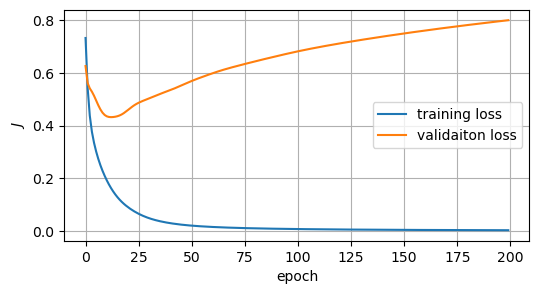

In [18]:
# do the actual training and plot the loss curves
model, train_J, valid_J = training(model, optimizer, J, 
                                   X_train, Y_train, 
                                   X_valid, Y_valid,
                                   num_epochs=200, out_epoch=20)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validaiton loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

Because all the data is normalised a loss value above 1 is actually a bad thing. In the above the training loss is decreasing and settling down as it should, but the validation loss is going up.

We can make predictions by running the model once more. In the below I wrapped out the prediction step with `torch.no_grad()` to force it to not do taping. Strictly speaking it doesn't matter if you never re-run the training again by restarting **properly**; see comment towards the end of the section.

In [19]:
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)
print(predictions_train[0:10, :])
print(" ")

tensor([[ 2.1317, -2.3081],
        [-2.7338,  2.4591],
        [ 8.0925, -8.0914],
        [-3.4989,  3.2609],
        [-4.4249,  3.8602],
        [ 7.0316, -6.5738],
        [-5.1307,  4.2445],
        [-3.7816,  4.3182],
        [-1.9957,  2.7362],
        [ 6.8147, -6.6412]])
 


The way to read the above output from the model for this classification problem is the score for the guess at position `0` (for dogs) and `1` for cats, and we want the **largest positive score**. We can pick out that by cycling through all the samples and using `np.argmax` argument, but we probably want to convert the tensor object back to numpy arrays; which can be done by the imbued function `.numpy()`. The below wraps up the various functions calls in one go as a subroutine, because I am going to reuse it again later.

In [20]:
# do model prediction and evaluate skill
def classification_skill(predictions, truths):
    dum = predictions.numpy()
    Y_pred = np.zeros(dum.shape[0])
    N = len(Y_pred)
    for i in range(N):
        Y_pred[i] = np.argmax(dum[i, :])
    skill_all = np.sum(Y_pred == truths.numpy())

    print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
def classification_plot(predictions, Y_test):

    dum = predictions.numpy()
    Y_pred = np.zeros(dum.shape[0])
    N = len(Y_pred)
    for i in range(N):
        Y_pred[i] = np.argmax(dum[i, :])
    
    fig = plt.figure(figsize=(10, 2))
    ax = plt.axes()
    ax.plot(Y_pred, 'bx', label="predictions")
    ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
    ax.set_ylim([-0.3, 1.3])
    ax.set_xlabel("index")
    ax.legend()
    ax.grid()
    
    accuracy = np.sum(Y_pred == Y_test.numpy()) / N
    ax.set_title(f"accuracy = {accuracy*100:.2f}%");

    return fig

training set:
overall skill: 112 correct out of 112 (100.00%)
 
test     set:
overall skill: 19 correct out of 24 (79.17%)
 


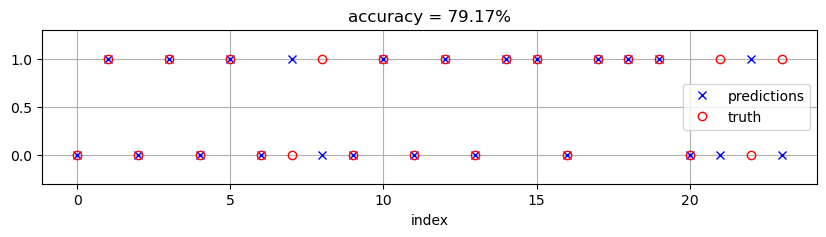

In [21]:
# evalute skill and plot actual predictions
print("training set:")
classification_skill(predictions_train, Y_train)
print("test     set:")
classification_skill(predictions_test, Y_test)

fig = classification_plot(predictions_test, Y_test)

So the above shows that we got all the training set classficiation correct (which is not too surprising), but it struggles on the test set, giving an accuracy that is not dissimilar to what we had last time with `sklearn` (with the understanding I used a different test size compared with before), so we have some consistency with previous results at least.

In the below code I am going to define three more networks, one to have ReLU activation, one to have `hidden_layer=(200, 50)`, and one with 5 layers. These give roughly the same amount of skill (subject to the same caveat).

> NOTE: Word of warning here. If you only run the training loop without re-initialising the model with `model = nn_classify_pets()` steps etc. it will probably restart from where you **just left off** rather than from zero. This is because the taping hasn't been cleared. If you have called `model` accordingly then it might do some intermediate taping, which may give you some weird things. It is best to start fresh, unless you really do mean to do restarts for whatever reason.

In [22]:
# define the networks

class nn_classify_pets_relu(nn.Module):
    def __init__(self):  # specify input dims below
        super(nn_classify_pets_relu, self).__init__()

        # nest it in one go
        self.layers = nn.Sequential(
            nn.Linear(64**2, 100),
            nn.ReLU(),              # with activation
            nn.Linear(100, 2)
        )

    # actual model structure: input -> hidden layer -> outputs, ReLU on input and hidden
    def forward(self, x):
        out =  self.layers(x)
        return out

class nn_classify_pets_2layers(nn.Module):
    def __init__(self):  # specify input dims below
        super(nn_classify_pets_2layers, self).__init__()

        # nest it in one go (two hidden layers, 64**2 -> 200 -> 50 -> 2)
        self.layers = nn.Sequential(
            nn.Linear(64**2, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 2)
        )

    def forward(self, x):
        out =  self.layers(x)
        return out

class nn_classify_pets_3layers(nn.Module):
    def __init__(self): 
        super(nn_classify_pets_3layers, self).__init__()

        # (3 hidden layers, 64**2 -> 400 -> 200 -> 100 -> 2)
        self.layers = nn.Sequential(
            nn.Linear(64**2, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 2)
        )
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.layers(x)
        out = self.sigmoid(out) # last activation important
        return out

Epoch 20/200, Train Loss: 0.1151, Validation Loss: 0.3411
Epoch 40/200, Train Loss: 0.0363, Validation Loss: 0.3325
Epoch 60/200, Train Loss: 0.0178, Validation Loss: 0.3370
Epoch 80/200, Train Loss: 0.0112, Validation Loss: 0.3451
Epoch 100/200, Train Loss: 0.0079, Validation Loss: 0.3544
Epoch 120/200, Train Loss: 0.0059, Validation Loss: 0.3626
Epoch 140/200, Train Loss: 0.0046, Validation Loss: 0.3703
Epoch 160/200, Train Loss: 0.0037, Validation Loss: 0.3774
Epoch 180/200, Train Loss: 0.0030, Validation Loss: 0.3838
Epoch 200/200, Train Loss: 0.0026, Validation Loss: 0.3897


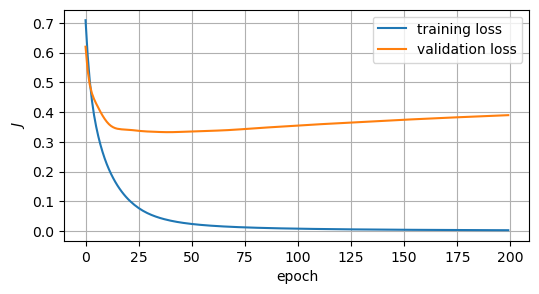

In [23]:
# initialisations
torch.manual_seed(1234)

model = nn_classify_pets_relu()
learning_rate = 0.0001
J = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

# do the actual training
model, train_J, valid_J = training(model, optimizer, J, X_train, Y_train, X_valid, Y_valid,
                                   num_epochs=200, out_epoch=20)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

training set:
overall skill: 112 correct out of 112 (100.00%)
 
test     set:
overall skill: 20 correct out of 24 (83.33%)
 


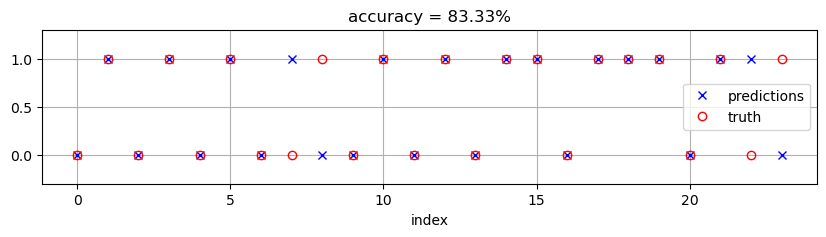

In [24]:
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

print("training set:")
classification_skill(predictions_train, Y_train)
print("test     set:")
classification_skill(predictions_test, Y_test)

fig = classification_plot(predictions_test, Y_test)

Epoch 20/200, Train Loss: 0.1798, Validation Loss: 0.2955
Epoch 40/200, Train Loss: 0.0427, Validation Loss: 0.2414
Epoch 60/200, Train Loss: 0.0141, Validation Loss: 0.2483
Epoch 80/200, Train Loss: 0.0068, Validation Loss: 0.2578
Epoch 100/200, Train Loss: 0.0041, Validation Loss: 0.2667
Epoch 120/200, Train Loss: 0.0028, Validation Loss: 0.2748
Epoch 140/200, Train Loss: 0.0020, Validation Loss: 0.2819
Epoch 160/200, Train Loss: 0.0016, Validation Loss: 0.2890
Epoch 180/200, Train Loss: 0.0012, Validation Loss: 0.2954
Epoch 200/200, Train Loss: 0.0010, Validation Loss: 0.3014


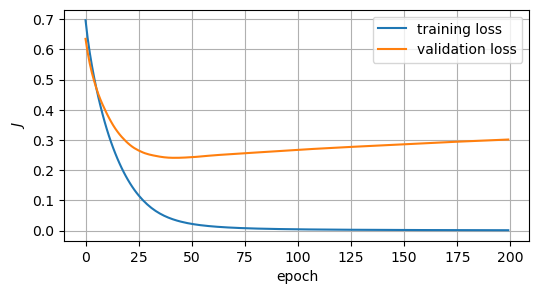

In [25]:
# initialisations
torch.manual_seed(1234)

model = nn_classify_pets_2layers()
learning_rate = 0.0001
J = nn.CrossEntropyLoss()  # for classification tasks, H = -p log q
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

# do the actual training
model, train_J, valid_J = training(model, optimizer, J, X_train, Y_train, X_valid, Y_valid,
                                   num_epochs=200, out_epoch=20)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

training set:
overall skill: 112 correct out of 112 (100.00%)
 
test     set:
overall skill: 20 correct out of 24 (83.33%)
 


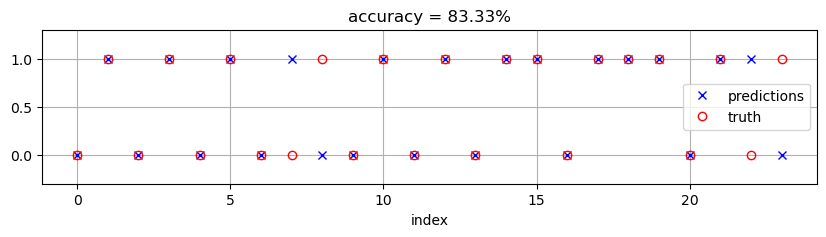

In [26]:
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

print("training set:")
classification_skill(predictions_train, Y_train)
print("test     set:")
classification_skill(predictions_test, Y_test)

fig = classification_plot(predictions_test, Y_test)

Epoch 20/200, Train Loss: 0.5427, Validation Loss: 0.5500
Epoch 40/200, Train Loss: 0.3834, Validation Loss: 0.4419
Epoch 60/200, Train Loss: 0.3272, Validation Loss: 0.4079
Epoch 80/200, Train Loss: 0.3172, Validation Loss: 0.4060
Epoch 100/200, Train Loss: 0.3149, Validation Loss: 0.4058
Epoch 120/200, Train Loss: 0.3142, Validation Loss: 0.4054
Epoch 140/200, Train Loss: 0.3138, Validation Loss: 0.4049
Epoch 160/200, Train Loss: 0.3137, Validation Loss: 0.4044
Epoch 180/200, Train Loss: 0.3136, Validation Loss: 0.4041
Epoch 200/200, Train Loss: 0.3135, Validation Loss: 0.4039


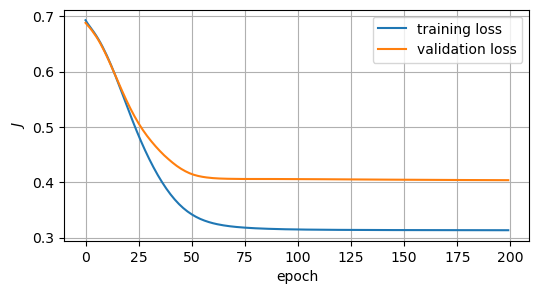

In [27]:
# initialisations
torch.manual_seed(1234)

model = nn_classify_pets_3layers()
learning_rate = 0.0001
J = nn.CrossEntropyLoss()  # for classification tasks, H = -p log q
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

# do the actual training
model, train_J, valid_J = training(model, optimizer, J, X_train, Y_train, X_valid, Y_valid,
                                   num_epochs=200, out_epoch=20)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

training set:
overall skill: 112 correct out of 112 (100.00%)
 
test     set:
overall skill: 19 correct out of 24 (79.17%)
 


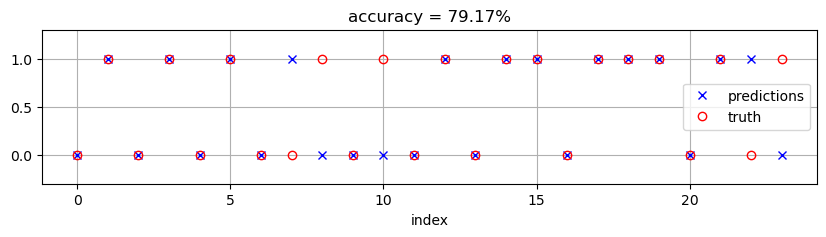

In [28]:
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

print("training set:")
classification_skill(predictions_train, Y_train)
print("test     set:")
classification_skill(predictions_test, Y_test)

fig = classification_plot(predictions_test, Y_test)

To close the very quick intro to using `PyTorch`, we can print out the model as `model.state_dict()`. This can then be saved and loaded accordingly as

```Python
    torch.save(model.state_dict(), "model_001.pth")
    print("Saved PyTorch Model State to model_001.pth")
    model = nn_model()  # or whatever you defined the class to be
    model.load_state_dict(torch.load("model_001.pth"))
```

In [29]:
# print out the mode to have a look
model.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[-0.0141, -0.0031, -0.0106,  ...,  0.0203,  0.0150,  0.0082],
                      [-0.0032,  0.0112, -0.0171,  ..., -0.0131, -0.0189, -0.0093],
                      [ 0.0047,  0.0006,  0.0010,  ..., -0.0083,  0.0073, -0.0005],
                      ...,
                      [ 0.0061, -0.0083, -0.0218,  ..., -0.0047, -0.0070, -0.0152],
                      [ 0.0085,  0.0168,  0.0106,  ...,  0.0060, -0.0021,  0.0100],
                      [ 0.0005, -0.0075, -0.0034,  ..., -0.0155,  0.0131,  0.0101]])),
             ('layers.0.bias',
              tensor([ 0.0145,  0.0106,  0.0106,  0.0169,  0.0137,  0.0077,  0.0174, -0.0067,
                       0.0096, -0.0040,  0.0142, -0.0102, -0.0045, -0.0024,  0.0092,  0.0029,
                       0.0008, -0.0094,  0.0130,  0.0119, -0.0031,  0.0087,  0.0012,  0.0046,
                      -0.0089,  0.0209, -0.0025,  0.0169,  0.0082,  0.0105, -0.0086,  0.0130,
                       0.0

One main constraint you should be careful about is the neural network size: MLPs by construction are all fully connected, so your parameter space increases very quickly with the number of nodes/layers. You could try putting this on a GPU for bigger networks etc., but there are quite a few details you will need to add in (which we will come to in two sessions time).

> <span style="color:red">Q.</span> I have personally not found decreasing `learning_rate` to help with the classification task that much, but see what happens if you decrease it further. You could try increasing it, but for me the loss function on the test set blows up fairly spectacularly...
>
> <span style="color:red">Q.</span> Try exploring other classification relevant loss functions.
>
> <span style="color:red">Q.</span> One thing that is used to stablise the problem and/or to avoid overfitting is to have ***early stopping***, which stops the training once the model training is not improving that much. Have a look how to implement this (in `PyTorch` this is done as a `Handler` instance).
>
> <span style="color:red">Q.</span> Another thing that is used to stablise the problem and/or to avoid overfitting is to do ***dropout***. Have a look what that is and how to implement this.
>
> <span style="color:red">Q.</span> Another thing that is used to stablise the problem and/or to avoid overfitting is to stabilise the problem. This can be done in a bespoke way by changing the definition of the loss function (cf. linear models before, and PINNs later), but can also be done through the options specified through the optimiser. Have a see how you would do through `optim.SDG`, `optim.Adam` and/or `optim.AdamW` solver.

----------------
# More involved exercises with this notebook

## 1) Code your own neural network by hand

Define appropriate inputs and outputs (e.g. $Y = X$, $Y = X^2$, $Y = \sin (X)$), use a non-trivial activation function and a loss function (MSE would be a good one). Link up the `simple_nn` subroutine with `scipy.optimize` to optimize for the parameters; the default L-BFGS solver will probably be fine.

If you've done that then you've successfully coded your own (simple) neural network by hand.

## 2) Penguins data

Try doing the classifer and regressors with the penguins data. I seriously doubt you need that much complexity in the networks for this though: the feature space dimension is low, and number of samples is not that high (in contrast to the cats + dogs data above, where the raw feature space dimension is large ($64^2$) but the sample size is probably not large enough to balance that out.

## 3) Turtle and penguins data

The Kaggle dataset of [penguins and turtles](https://www.kaggle.com/datasets/abbymorgan/penguins-vs-turtles) encountered previously might be better to do for neural network training; try doing stuff on that.

## 4) Time series data

Consider training regressors for doing time-series prediction, using the `elnino34_sst.data`, or from model data (e.g. Lotka-Volterra, Lorenz etc.)

If you want, try and do classifying problems, e.g. using a few data points before to predict whether there will be an upcoming El-Nino / La Nina episode. This requires you to provide labels to the data first, but you should know how to do that in principle already from the exercises in the previous sessions.

## 5) More data is always a good thing?

Redo the above cats and dogs classification problem but only using the top or bottom half of the image (cf. exercise 7 below if you want some code that may be useful for the data processing). I personally find I can get high accuracy with a smaller/simpler network than if I throw in all the data (I can get up to 80% accuracy).

Possibly a demonstration that working smarter at the data processing stage can potentially yield more skill than throwing the whole kitchen sink in through the model complexity (cf. a well-designed experiment likely beats the fancy statistical tests you can do on the resulting data).

## 6) Extended cats dataset

This may require a bit more computing power than you would have in a regular instance, and may be worth skipping for now but revisiting in the next session when we deal with Convolutional Neural Networks. The extended cats dataset have 2000 images in (instead of the basic one with 80), which may or may not be better for training a regressor on. Try and train a regressor accordingly and quantify the skill in a way of your choosing.

You should note there are images within that dataset that may want to be excluded accordingly, as alluded to back in session 02 when we did eigencats.

## 7) MLP as regressors

You could try also the regression problem, although it might be easier to see this after the CNN section next time where I demonstrate it once anyway. Try predicting one half of the face with the other; see results I show in the lecture slides. 

See below for some code on how I tidied the data as top and bottom half; you could do left and right (the latter option is marginally simpler because of how the data is structured).

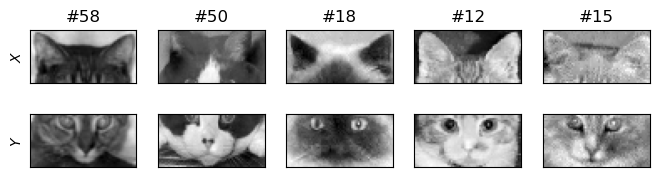

In [30]:
# subroutine to split top and bottom half of pixels: reshape, split, then flatten for sklearn
def split_top_bottom(data):
    n, width = data.shape[0], int(np.sqrt(data.shape[1]))
    data = np.reshape(data, (n, width, width))
    top_half, bottom_half = data[:, :, 0:width//2], data[:, :, width//2::]
    top_half = np.reshape(top_half, (n, width*width//2))
    bottom_half = np.reshape(bottom_half, (n, width*width//2))

    return top_half, bottom_half

# shape of "cats" here is (pixels, index), so it is already flattened
n = 64

# manually split up into train and test
X_train, Y_train = split_top_bottom(X_cats[:n, :])
X_test, Y_test = split_top_bottom(X_cats[n::, :])

# scale the data
scale_X, scale_Y = StandardScaler().fit(X_train), StandardScaler().fit(Y_train)
X_train, X_test = scale_X.transform(X_train), scale_X.transform(X_test)
Y_train, Y_test = scale_Y.transform(Y_train), scale_Y.transform(Y_test)

# generate a list of 25 indices (generate full list, shuffle, select first 25, so no repeats)
ind = np.arange(n)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

# sample show (on-the-fly reshape data)
fig = plt.figure(figsize=(8, 2))
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 32)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    if i == 0:
        ax.set_ylabel("$X$")
    ax.set_xticks([]); ax.set_yticks([]);

    ax = plt.subplot(2, 5, i+1+5)
    ax.imshow(np.reshape(Y_train[ind[i], :], (64, 32)).T, cmap="gray")
    if i == 0:
        ax.set_ylabel("$Y$")
    ax.set_xticks([]); ax.set_yticks([]);